### Load Dataset

In [20]:
# LOAD CSV dataset
import pandas as pd
import numpy as np

# Load the dataset
df_filled_ml_copy = pd.read_csv('bed_cleaned_data_2025.csv') #'bed_cleaned_data.csv', isthe old 2024 data
df_filled_ml_copy.drop(columns=['Unnamed: 0'], inplace=True)
#set Item_NO to 8 digits with zfill
df_filled_ml_copy['Item_NO'] = df_filled_ml_copy['Item_NO'].apply(lambda x: str(x).zfill(8))

df_original = df_filled_ml_copy.copy()

df_filled_ml_copy.drop(columns=['Item_NO'], inplace=True)

df_filled_ml_copy.info()

colour = "colour.json"
colour_df = pd.read_json(colour)
colour_df['item_no'] = colour_df['item_no'].apply(lambda x: str(x).zfill(8))

bed_colour = "bed_colour.json"
bed_colour_df = pd.read_json(bed_colour)
bed_colour_df['item_no'] = bed_colour_df['item_no'].apply(lambda x: str(x).zfill(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Product_Name       2781 non-null   object
 1   length             2781 non-null   int64 
 2   width              2781 non-null   int64 
 3   Product_Type_Name  2781 non-null   object
 4   material           2781 non-null   object
 5   PA_Name            2781 non-null   object
 6   VALDES_TEXT_EN     2781 non-null   object
 7   country_code       2781 non-null   object
 8   language_code      2781 non-null   object
dtypes: int64(2), object(7)
memory usage: 195.7+ KB


### Preprocess text data

In [21]:
import re
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Install NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # # Remove punctuation
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Remove extra whitespace
    text = text.strip()
    return text

df_no_dimensions = df_filled_ml_copy.drop(columns=['length', 'width'])
df_no_dimensions.columns = [col.lower() for col in df_no_dimensions.columns]

df_prepocess = pd.DataFrame()
for column in df_no_dimensions.columns:
    df_prepocess[column] = df_no_dimensions[column].apply(preprocess_text)

# put back the dimensions
df_prepocess['length'] = df_filled_ml_copy['length']
df_prepocess['width'] = df_filled_ml_copy['width']

df_colour = pd.DataFrame()
for column in bed_colour_df.columns:
    df_colour[column] = bed_colour_df[column].apply(preprocess_text)
    
df_color = pd.DataFrame()
for column in colour_df.columns:
    df_color[column] = colour_df[column].apply(preprocess_text)
print(df_prepocess.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\QUTRA9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  product_name  product_type_name              material  \
0       nordli  bed frame storage  wood including board   
1       utåker      stackable bed            solid wood   
2       idanäs  bed frame storage  wood including board   
3    kleppstad          bed frame                 metal   
4    vevelstad          bed frame                 metal   

                                      pa_name     valdes_text_en country_code  \
0  bed frames beds non upholstered headboards              white           se   
1                    flexible sleep solutions               pine           se   
2  bed frames beds non upholstered headboards              white           se   
3                   bed upholstered headboard  whitevissle beige           se   
4  bed frames beds non upholstered headboards              white           se   

  language_code  length  width  
0            en     160    200  
1            en      80    200  
2            en     180    200  
3            en     140   

Joining color data

In [22]:
df_prepocess['item_no'] = df_original['Item_NO']
df_color['item_no'] = colour_df['item_no']
df_colour['item_no'] = bed_colour_df['item_no']
#df_merge = []
df_merge = pd.merge(df_prepocess, df_colour[['item_no','VALUES']], how='left', left_on='item_no', right_on='item_no')
df_merge = pd.merge(df_merge, df_color[['item_no','text']], how='left', left_on='item_no', right_on='item_no')


### Fill missing colors

In [23]:
colour_list = df_merge['text'].unique().tolist()

# Fill missing values in 'text' column with values from 'VALUES' column
df_merge['text'] = df_merge['text'].fillna(df_merge['VALUES'])

# Search for colors in 'valdes_text_en' column and replace missing values in 'text' column
def find_color_in_text(text, color_list):
    for color in color_list:
        if pd.notna(color) and color in text:
            return color
    return np.nan

df_merge['text'] = df_merge.apply(
    lambda row: find_color_in_text(row['valdes_text_en'], colour_list) if pd.isna(row['text']) else row['text'],
    axis=1
)

# Fill remaining missing values in 'text' column with 'None'
df_merge['text'] = df_merge['text'].fillna('None')

# drop item_no, VALUES, country and language columns
df_merge.drop(columns=['VALUES', 'country_code', 'language_code'], inplace=True)

Drop duplicates item_no

------------------------

In [24]:
# drop duplicate rows
df_test = df_merge.drop_duplicates()

# find item_no that are duplicates
duplicates = df_test[df_test.duplicated(subset=['item_no'], keep=False)]

# concatenate the text values of duplicate item_no
duplicates_grouped = duplicates.groupby('item_no')['text'].apply(lambda x: ' '.join(x)).reset_index()

# replace the values in text column in df_test with concatenated values
df_test = pd.merge(df_test, duplicates_grouped, how='left', on='item_no')


In [25]:
# for values in text_y that are not missing, replace text_x with text_y
df_test['text_x'] = df_test.apply(
    lambda row: row['text_y'] if pd.notna(row['text_y']) else row['text_x'],
    axis=1
)

df_test.drop(columns=['text_y'], inplace=True)
df_test.rename(columns={'text_x': 'text'}, inplace=True)


In [26]:
#drop duplicates
df_test.drop_duplicates(subset=['item_no'], inplace=True)

-----------------

Testing

In [27]:
df_merge = df_test.copy()

-------

### Similarity Clustering using Cosine similarity

In [45]:
df_short_random_sample = df_prepocess.sample(60)
df_short_random_sample_color = df_merge.sample(100)

# save the data
df_short_random_sample.to_csv('short_random_sample.csv', index=False)
df_short_random_sample_color.to_csv('short_random_sample_color.csv', index=False)

Working

--------------

In [52]:
import pandas as pd
from itertools import islice

df = df_merge.copy()

df['size'] = df['length'].astype(str) + ' x ' + df['width'].astype(str)
df.drop(columns=['length', 'width'], inplace=True)
grouped = df.groupby(['product_name','product_type_name'])

def create_groups(group):
    # sort by .... to ensure variety
    group = group.sort_values(by=["text", "valdes_text_en", "material", "size"])
    groups = []
    # ensure variety within each group
    for i in range(0, len(group), 6):
        subset = group.iloc[i:i+6]
        
        if subset["size"].nunique() >= 1:  # Ensure at least x unique sizes
            groups.append(subset)
    return groups

result = []
for name, group in grouped:
    result.extend(create_groups(group))
    
for i, group in enumerate(result):
    print(f"Group {i + 1}:")
    print(group)
    print()

# set group number
group_number = 1
for group in result:
    group['group'] = group_number
    group_number += 1
    
# Concatenate the groups
df_grouped = pd.concat(result)

Group 1:
    product_name product_type_name     material                    pa_name  \
467   blåfjället         divan bed  upholstered  bed upholstered headboard   
318   blåfjället         divan bed  upholstered  bed upholstered headboard   
483   blåfjället         divan bed  upholstered  bed upholstered headboard   
243   blåfjället         divan bed  upholstered  bed upholstered headboard   
399   blåfjället         divan bed  upholstered  bed upholstered headboard   
622   blåfjället         divan bed  upholstered  bed upholstered headboard   

                  valdes_text_en   item_no       text       size  
467       medium firmvissle blue  69515172       blue  140 x 200  
318       medium firmvissle blue  49515173       blue  160 x 200  
483       medium firmvissle blue  69561946       blue  180 x 200  
243  medium firmkabusa dark grey  39515178  dark grey  140 x 200  
399  medium firmkabusa dark grey  59515177  dark grey  160 x 200  
622  medium firmkabusa dark grey  89561945

----

Working with Debugg mode, improved the group logic function

------

In [28]:
import pandas as pd
from itertools import islice

df = df_merge.copy()

# Combine 'length' and 'width' into a single 'size' column
df['size'] = df['length'].astype(str) + ' x ' + df['width'].astype(str)
df.drop(columns=['length', 'width'], inplace=True)

# Group by 'product_name' and 'product_type_name'
grouped = df.groupby(['product_name', 'product_type_name'])

def create_groups(group, subset_size=6, min_unique_sizes=1):
    
    group = group.sort_values(by=["text", "valdes_text_en", "material", "size"])
    groups = []
    for i in range(0, len(group), subset_size):
        subset = group.iloc[i:i+subset_size]
        if subset["size"].nunique() >= min_unique_sizes:
            groups.append(subset)
        else:
            print(f"Excluded subset with {subset.shape[0]} rows due to insufficient unique sizes")
    return groups

result = []
for name, group in grouped:
    result.extend(create_groups(group))

# Print the number of groups created
print(f"Total groups created: {len(result)}")

# Print each group for debugging
for i, group in enumerate(result):
    print(f"Group {i + 1}:")
    print(group)
    print()

# Set group number
group_number = 1
for group in result:
    group['group'] = group_number
    group_number += 1

# Concatenate the groups
df_grouped = pd.concat(result)

# Print initial and final row counts for debugging
print(f"Initial rows: {len(df_merge)}")
print(f"Final rows: {len(df_grouped)}")

Total groups created: 581
Group 1:
    product_name    product_type_name material    pa_name  valdes_text_en  \
984    backsälen  cover seat armchair   fabric  armchairs    hallarp grey   
980    backsälen  cover seat armchair   fabric  armchairs  katorp natural   
979    backsälen  cover seat armchair   fabric  armchairs  blekinge white   

      item_no     text     size  
984  40497263     grey  55 x 50  
980  10497231  natural  55 x 50  
979  10497132    white  55 x 50  

Group 2:
    product_name product_type_name material pa_name  valdes_text_en   item_no  \
978    backsälen   cover seat sofa   fabric   sofas    hallarp grey  00497255   
982    backsälen   cover seat sofa   fabric   sofas    hallarp grey  20497259   
981    backsälen   cover seat sofa   fabric   sofas  katorp natural  20497235   
983    backsälen   cover seat sofa   fabric   sofas  katorp natural  40497239   
977    backsälen   cover seat sofa   fabric   sofas  blekinge white  00497199   
985    backsälen   cover

--------

In [29]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2781 entries, 984 to 707
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_name       2781 non-null   object
 1   product_type_name  2781 non-null   object
 2   material           2781 non-null   object
 3   pa_name            2781 non-null   object
 4   valdes_text_en     2781 non-null   object
 5   item_no            2781 non-null   object
 6   text               2781 non-null   object
 7   size               2781 non-null   object
 8   group              2781 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 217.3+ KB


In [30]:
df_grouped['group'].value_counts().describe()


count    581.000000
mean       4.786575
std        1.805898
min        1.000000
25%        4.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: count, dtype: float64

In [31]:
df_grouped['group'].value_counts()

group
291    6
286    6
297    6
296    6
295    6
      ..
108    1
107    1
388    1
329    1
216    1
Name: count, Length: 581, dtype: int64

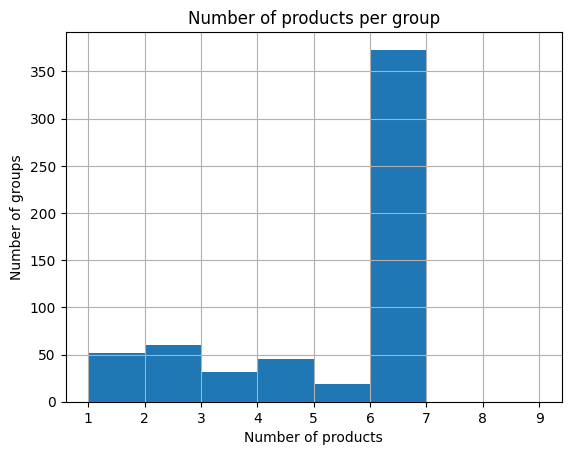

In [33]:
# plot histogram number of products per group
import matplotlib.pyplot as plt

plt.hist(df_grouped['group'].value_counts(), bins=range(1, 10))
plt.xlabel('Number of products')
plt.ylabel('Number of groups')
plt.title('Number of products per group')
plt.grid(True)
plt.show()

In [34]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2781 entries, 984 to 707
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_name       2781 non-null   object
 1   product_type_name  2781 non-null   object
 2   material           2781 non-null   object
 3   pa_name            2781 non-null   object
 4   valdes_text_en     2781 non-null   object
 5   item_no            2781 non-null   object
 6   text               2781 non-null   object
 7   size               2781 non-null   object
 8   group              2781 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 217.3+ KB


In [35]:
# save the data
df_grouped.to_csv('grouped_data_2025.csv', index=False)
# save the data json
df_grouped.to_json('grouped_data_2025.json', orient='records')